# Jun 18-20, 2022: following PyTorch quickstart

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
LABELS = list(range(10))
IDX_LABELS = {}
for v, k in enumerate(LABELS):
    IDX_LABELS[k] = v

In [4]:
tr_data = []
for idx in range(len(training_data)):
    img, label = training_data[idx]
    if label not in LABELS: continue
    tr_data.append((img, IDX_LABELS[label]))

te_data = []
for idx in range(len(test_data)):
    img, label = test_data[idx]
    if label not in LABELS: continue
    te_data.append((img, IDX_LABELS[label]))


In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(tr_data, batch_size=batch_size)
test_dataloader = DataLoader(te_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


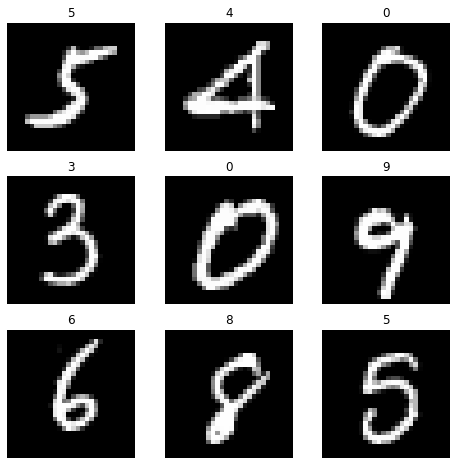

In [6]:
import matplotlib.pyplot as plt

labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, out_dim):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(len(LABELS)).to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303879  [    0/60000]
loss: 2.301385  [ 6400/60000]
loss: 2.292569  [12800/60000]
loss: 2.289856  [19200/60000]
loss: 2.293896  [25600/60000]
loss: 2.286589  [32000/60000]
loss: 2.268994  [38400/60000]
loss: 2.280642  [44800/60000]
loss: 2.266096  [51200/60000]
loss: 2.251800  [57600/60000]
Test Error: 
 Accuracy: 38.7%, Avg loss: 2.260369 

Epoch 2
-------------------------------
loss: 2.259393  [    0/60000]
loss: 2.252687  [ 6400/60000]
loss: 2.255758  [12800/60000]
loss: 2.233857  [19200/60000]
loss: 2.247922  [25600/60000]
loss: 2.239133  [32000/60000]
loss: 2.211809  [38400/60000]
loss: 2.238317  [44800/60000]
loss: 2.207583  [51200/60000]
loss: 2.190719  [57600/60000]
Test Error: 
 Accuracy: 57.8%, Avg loss: 2.199494 

Epoch 3
-------------------------------
loss: 2.195975  [    0/60000]
loss: 2.182597  [ 6400/60000]
loss: 2.201590  [12800/60000]
loss: 2.147905  [19200/60000]
loss: 2.177760  [25600/60000]
loss: 2.164878  [32000/600

In [12]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

model.eval()
x, y = test_data[10][0].to(device), test_data[10][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = labels_map[pred[0].argmax(0).item()], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "0", Actual: "0"


### saliency

In [13]:
from captum.attr import Saliency, IntegratedGradients

saliency = Saliency(model)
# saliency = IntegratedGradients(model, multiply_by_inputs=False)

In [14]:
import numpy as np
from tqdm import tqdm

attribs = [[] for _ in LABELS]
X_s = [None for _ in LABELS]

for idx_label, label in enumerate(LABELS):
    # print(idx_label)
    X_ = []
    for idx in range(len(te_data)):
        X, y = te_data[idx]
        if y != idx_label: continue
        X = X.to(device)
        X_.append(X)

    X_ = torch.stack(X_, dim=0)
    # print(X_.size(), X_.type())
    X_s[idx_label] = X_

    for idx_target, _ in tqdm(enumerate(LABELS)):
        attrs = []
        for idx in np.arange(X_s[idx_label].size()[0]):
            model.zero_grad()
            attrs.append(saliency.attribute(X_s[idx_label][idx], target=idx_target))
        attrs = torch.stack(attrs, dim=0)
        # print(attrs.type(), attrs.size())
        attribs[idx_label].append(attrs)

0it [00:00, ?it/s]/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
10it [00:20,  2.00s/it]
10it [00:22,  2.26s/it]
10it [00:21,  2.14s/it]
10it [00:20,  2.04s/it]
10it [00:19,  1.99s/it]
10it [00:18,  1.83s/it]
10it [00:19,  1.96s/it]
10it [00:20,  2.10s/it]
10it [00:20,  2.03s/it]
10it [00:20,  2.04s/it]


In [15]:
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

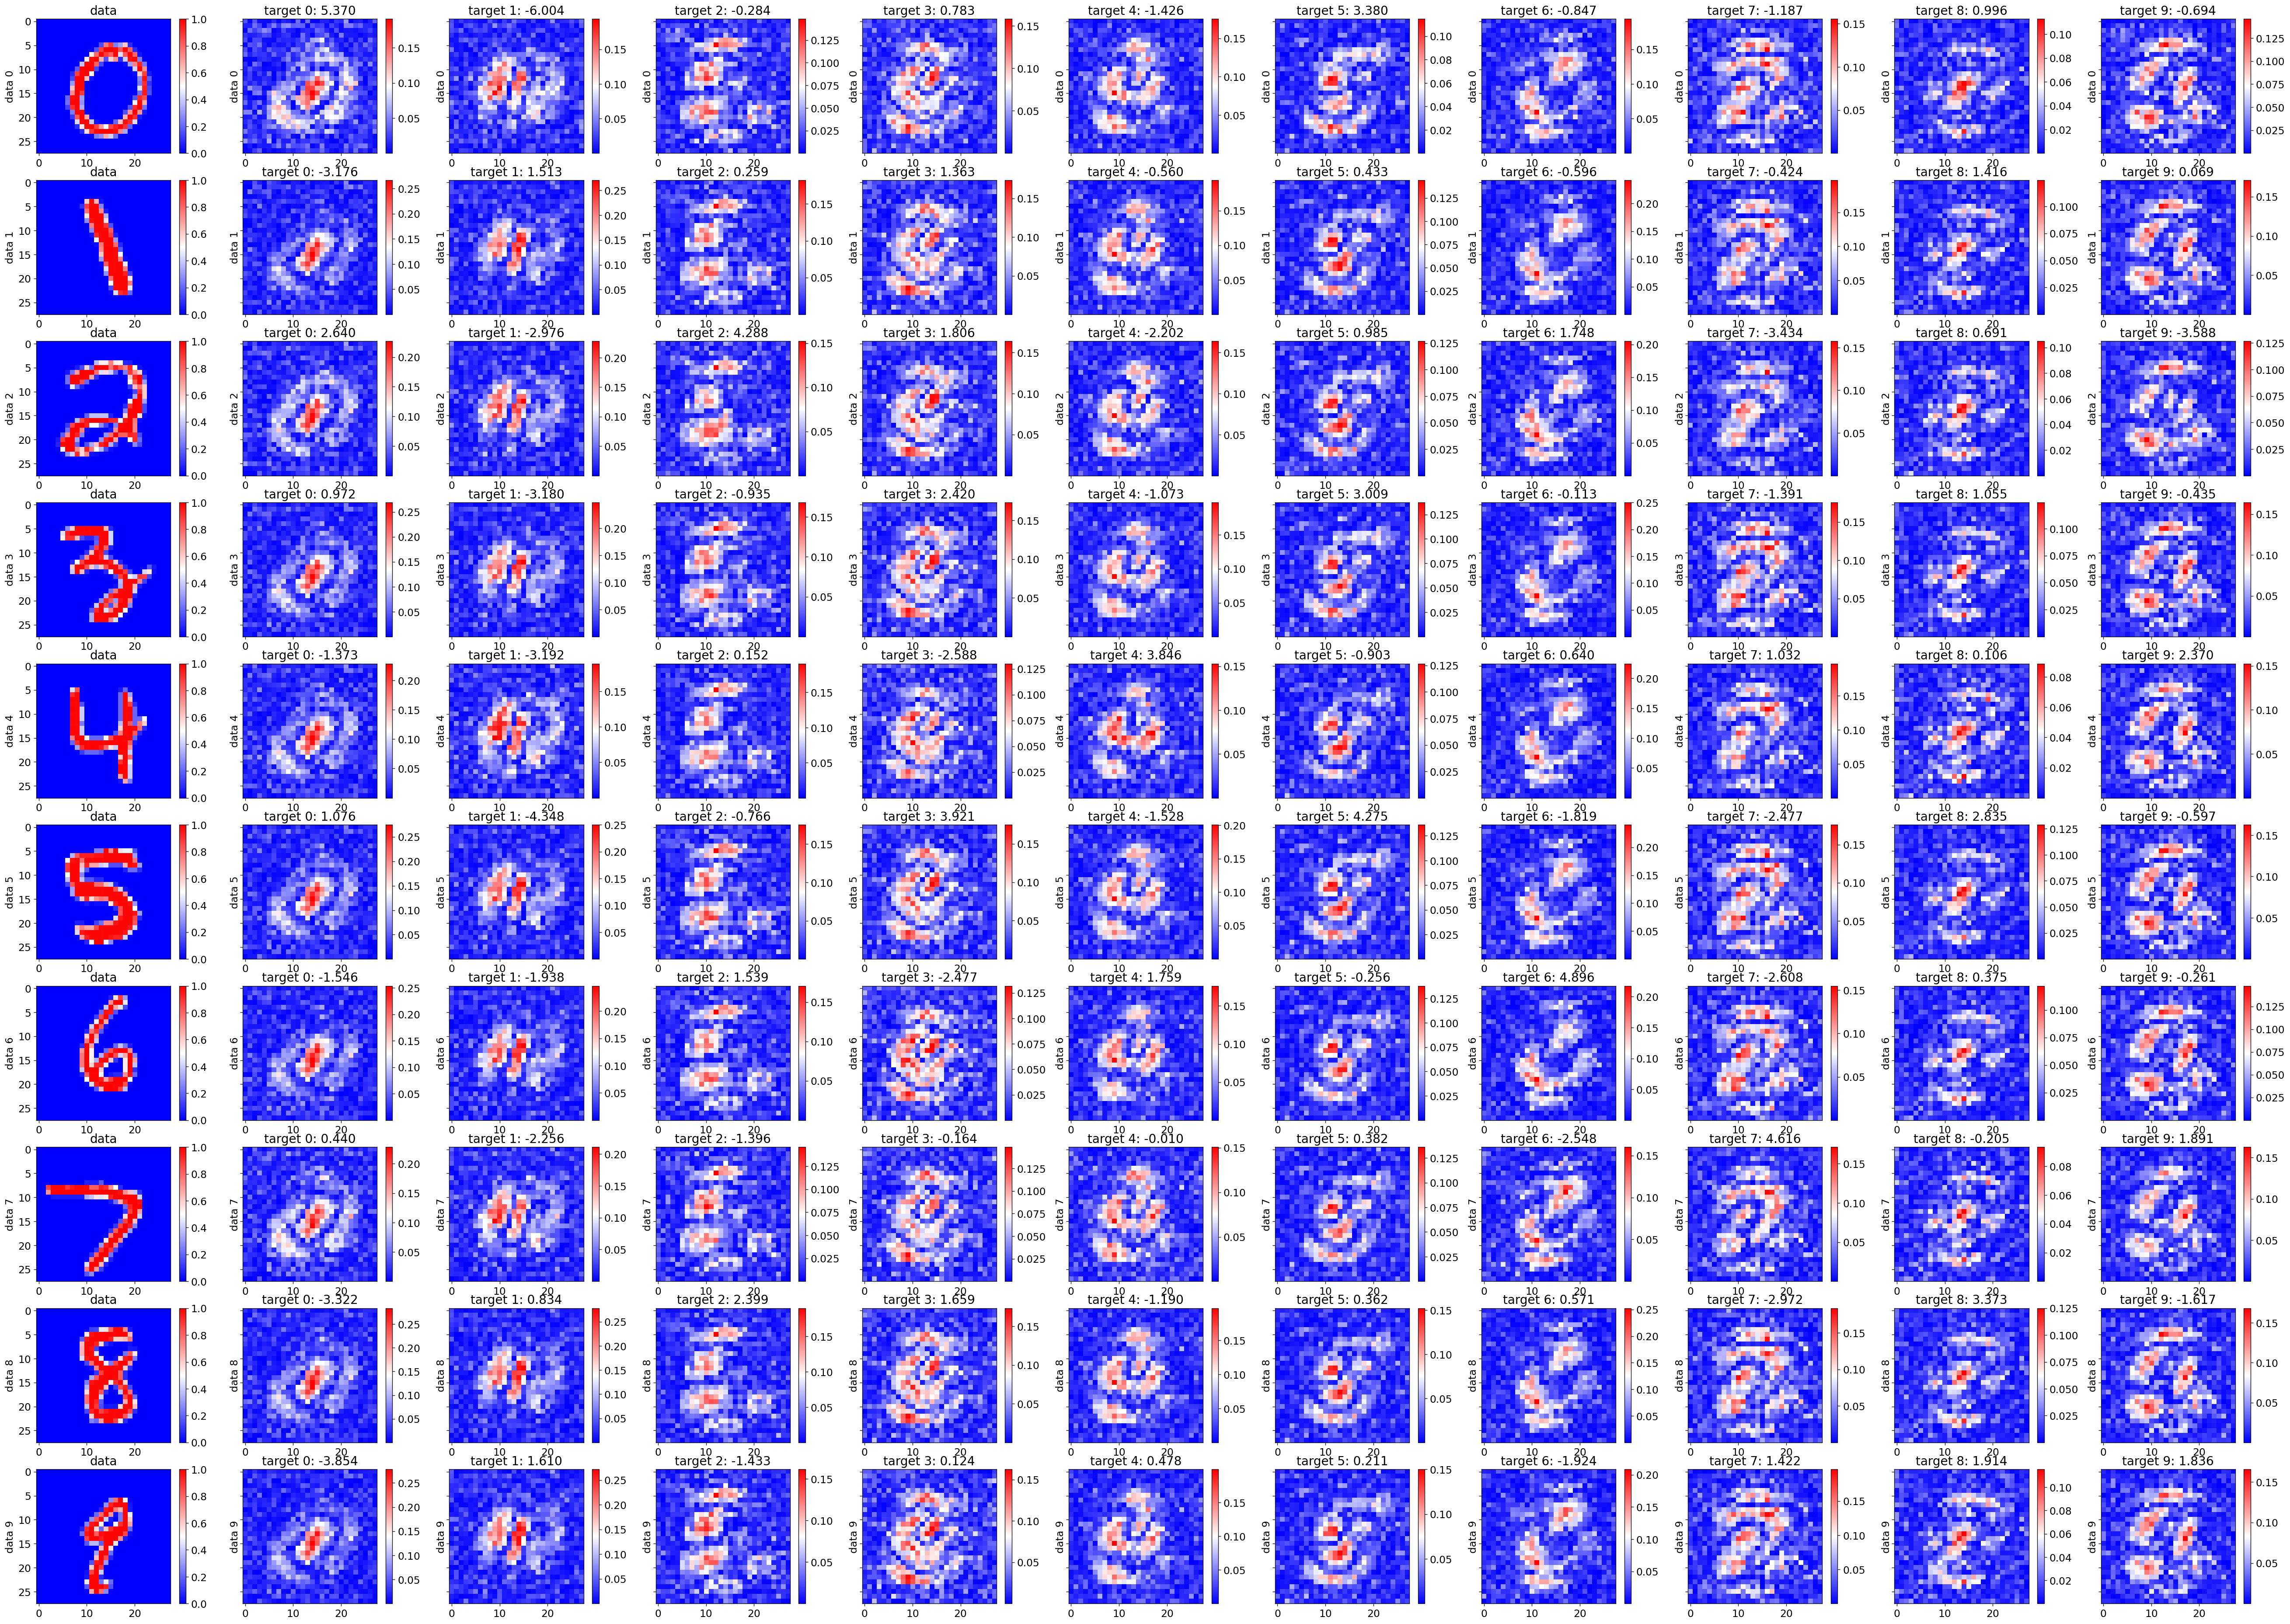

In [16]:
idx = 8

nrows, ncols = len(LABELS), len(LABELS)+1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=True, 
    dpi=120
)

for idx_label, label in enumerate(LABELS):
    ax = axs[idx_label][0]
    im = ax.imshow(X_s[idx_label][idx].squeeze().cpu(), cmap='bwr')
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_title(f"data")
    ax.set_ylabel(f"data {label}")

    pred = model(X_s[idx_label][idx]).cpu()[0]

    for idx_target, target_label in enumerate(LABELS):
        ax = axs[idx_label][idx_target+1]
        im = ax.imshow(attribs[idx_label][idx_target][idx].squeeze().cpu(), cmap='bwr')
        cbar = ax.figure.colorbar(im, ax=ax)
        ax.set_title(f"target {target_label}: {pred[idx_target]:.3f}")
        ax.set_ylabel(f"data {label}")

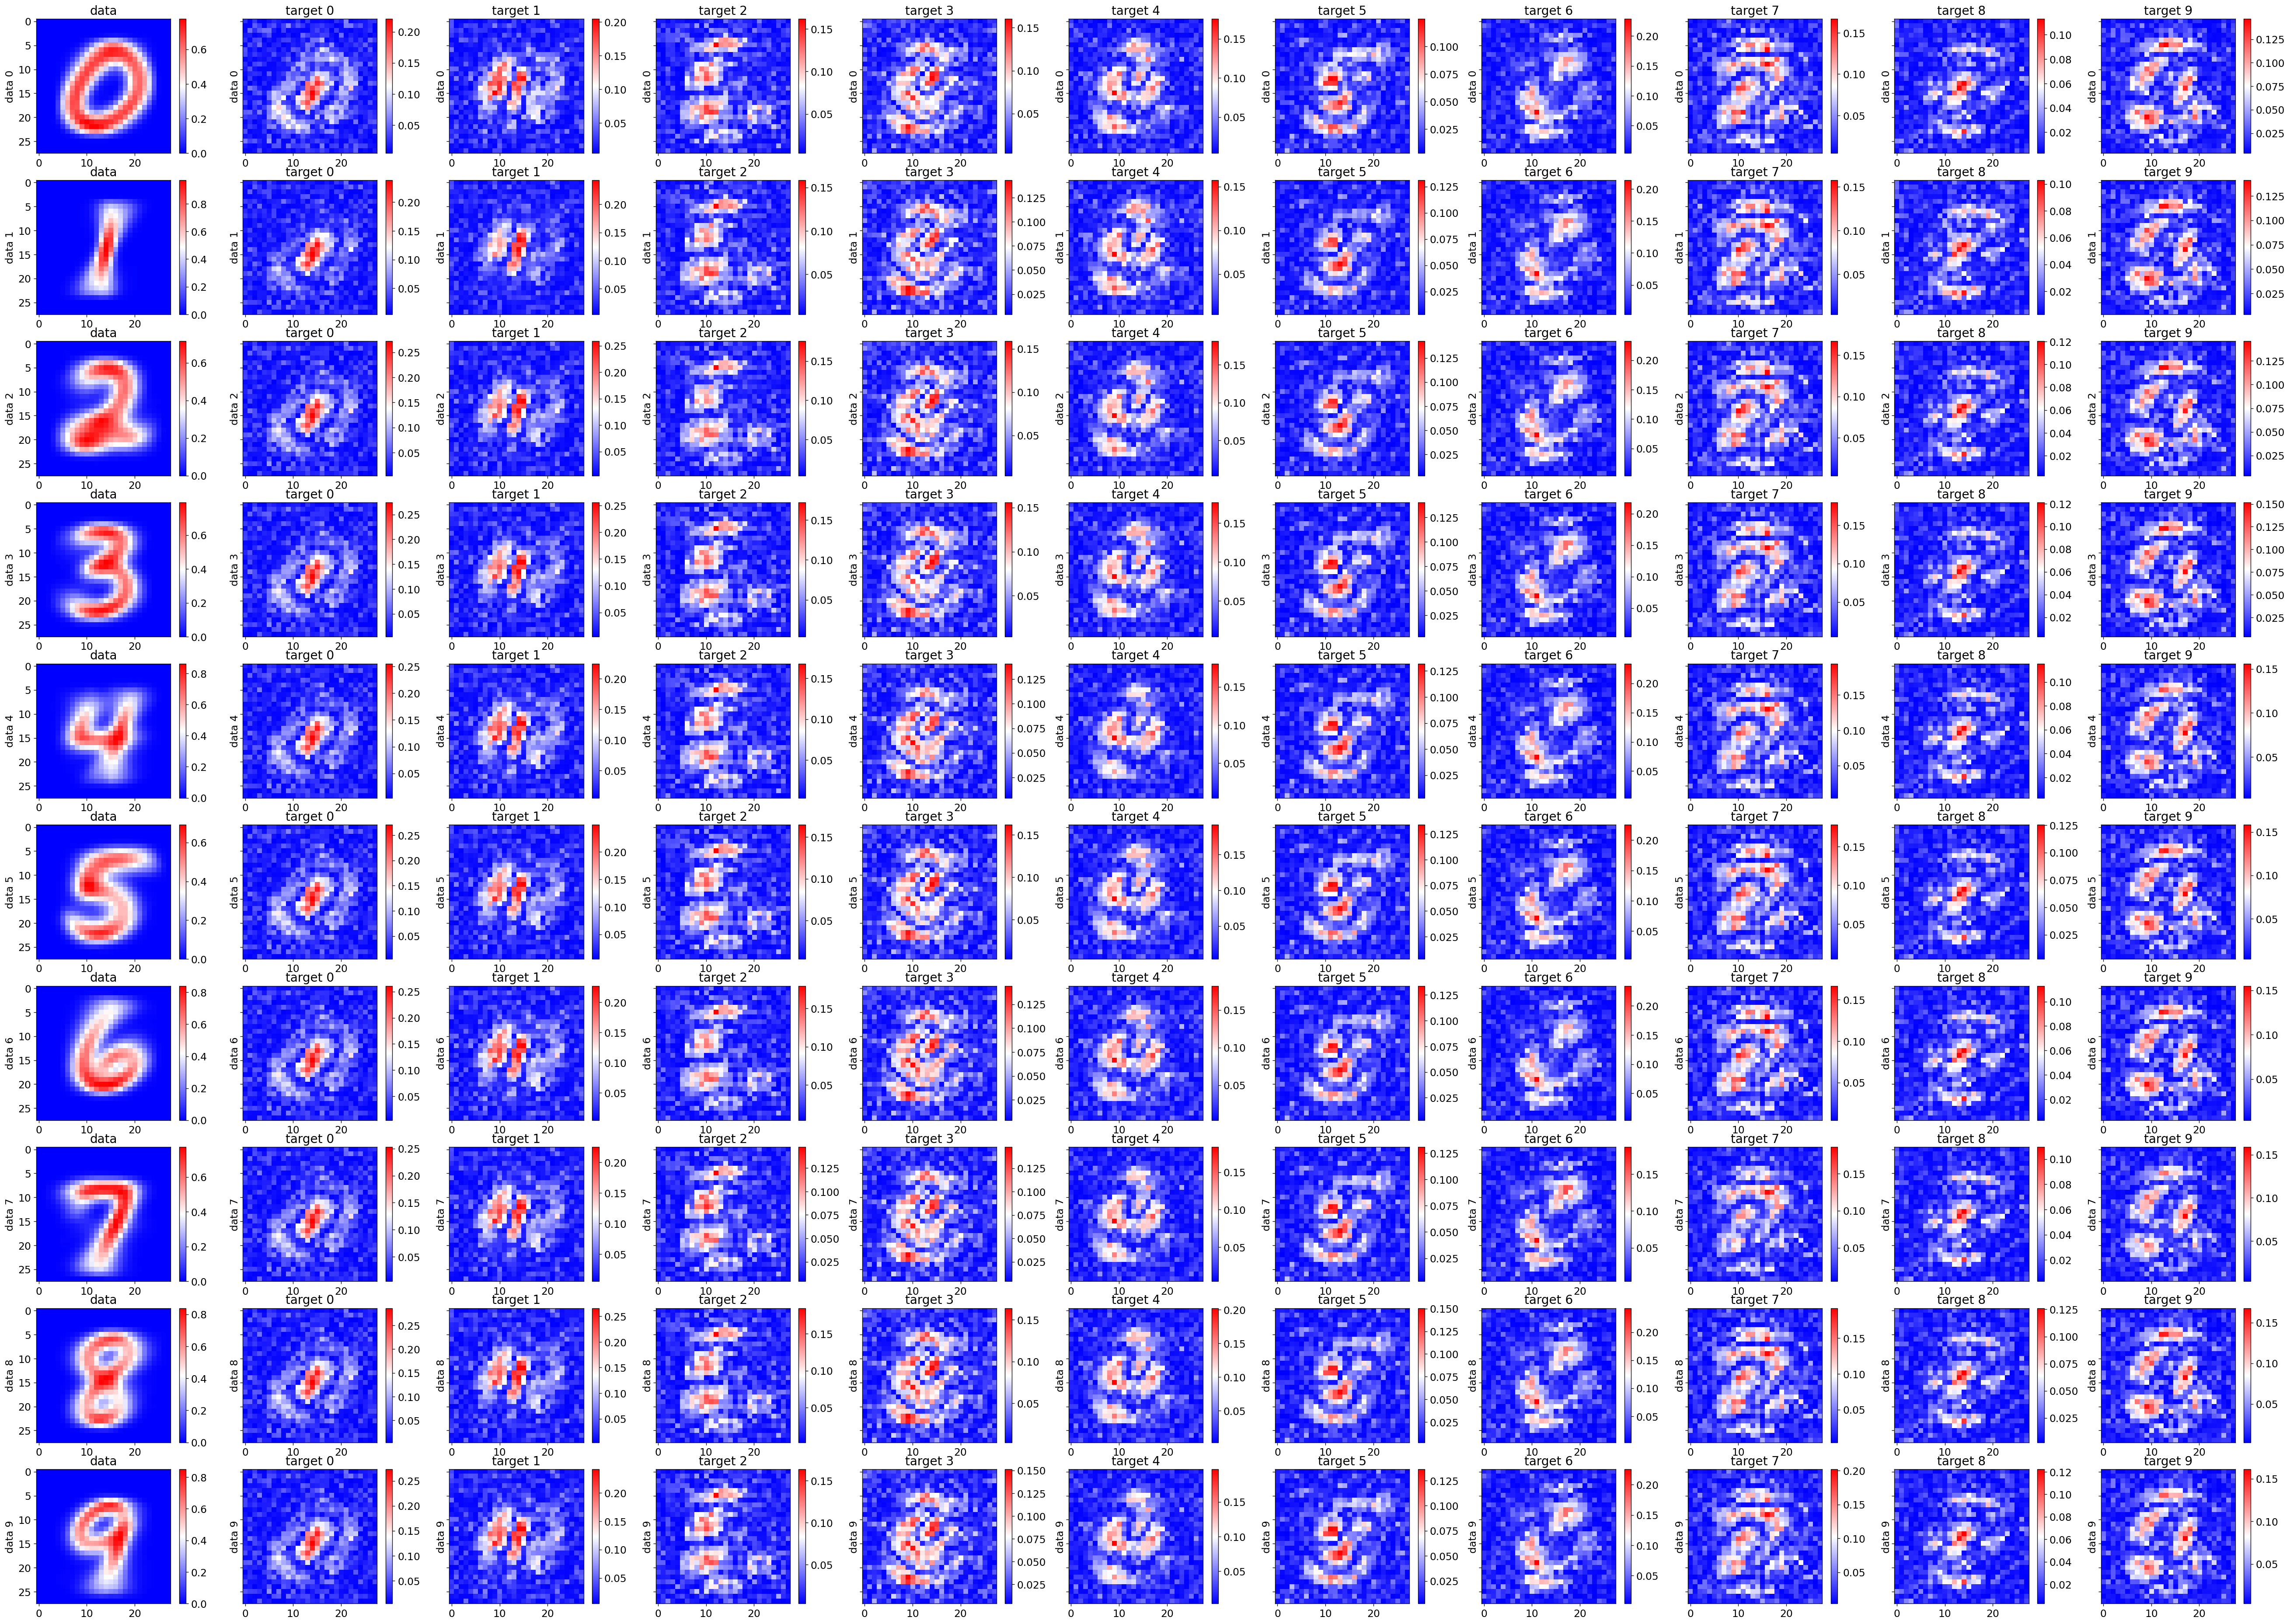

In [17]:
nrows, ncols = len(LABELS), len(LABELS)+1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=True, 
    dpi=120
)

for idx_label, label in enumerate(LABELS):
    ax = axs[idx_label][0]
    im = ax.imshow(torch.mean(X_s[idx_label], dim=0).squeeze().cpu(), cmap='bwr')
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_title(f"data")
    ax.set_ylabel(f"data {label}")


    for idx_target, target_label in enumerate(LABELS):
        ax = axs[idx_label][idx_target+1]
        im = ax.imshow(torch.mean(attribs[idx_label][idx_target], dim=0).squeeze().cpu(), cmap='bwr')
        cbar = ax.figure.colorbar(im, ax=ax)
        ax.set_title(f"target {target_label}")
        ax.set_ylabel(f"data {label}")

---------------
----------

### integrated gradients

In [18]:
from captum.attr import Saliency, IntegratedGradients

# saliency = Saliency(model)
saliency = IntegratedGradients(model, multiply_by_inputs=False)

In [19]:
import numpy as np
from tqdm import tqdm

attribs = [[] for _ in LABELS]
X_s = [None for _ in LABELS]

for idx_label, label in enumerate(LABELS):
    # print(idx_label)
    X_ = []
    for idx in range(len(te_data)):
        X, y = te_data[idx]
        if y != idx_label: continue
        X = X.to(device)
        X_.append(X)

    X_ = torch.stack(X_, dim=0)
    # print(X_.size(), X_.type())
    X_s[idx_label] = X_

    for idx_target, _ in tqdm(enumerate(LABELS)):
        attrs = []
        for idx in np.arange(X_s[idx_label].size()[0]):
            model.zero_grad()
            attrs.append(saliency.attribute(X_s[idx_label][idx], target=idx_target))
        attrs = torch.stack(attrs, dim=0)
        # print(attrs.type(), attrs.size())
        attribs[idx_label].append(attrs)

10it [01:02,  6.27s/it]
10it [01:11,  7.13s/it]
10it [01:04,  6.47s/it]
10it [01:03,  6.31s/it]
10it [01:00,  6.06s/it]
10it [00:56,  5.64s/it]
10it [01:00,  6.10s/it]
10it [01:04,  6.46s/it]
10it [01:02,  6.20s/it]
10it [01:02,  6.22s/it]


In [20]:
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

#### on typical data sample

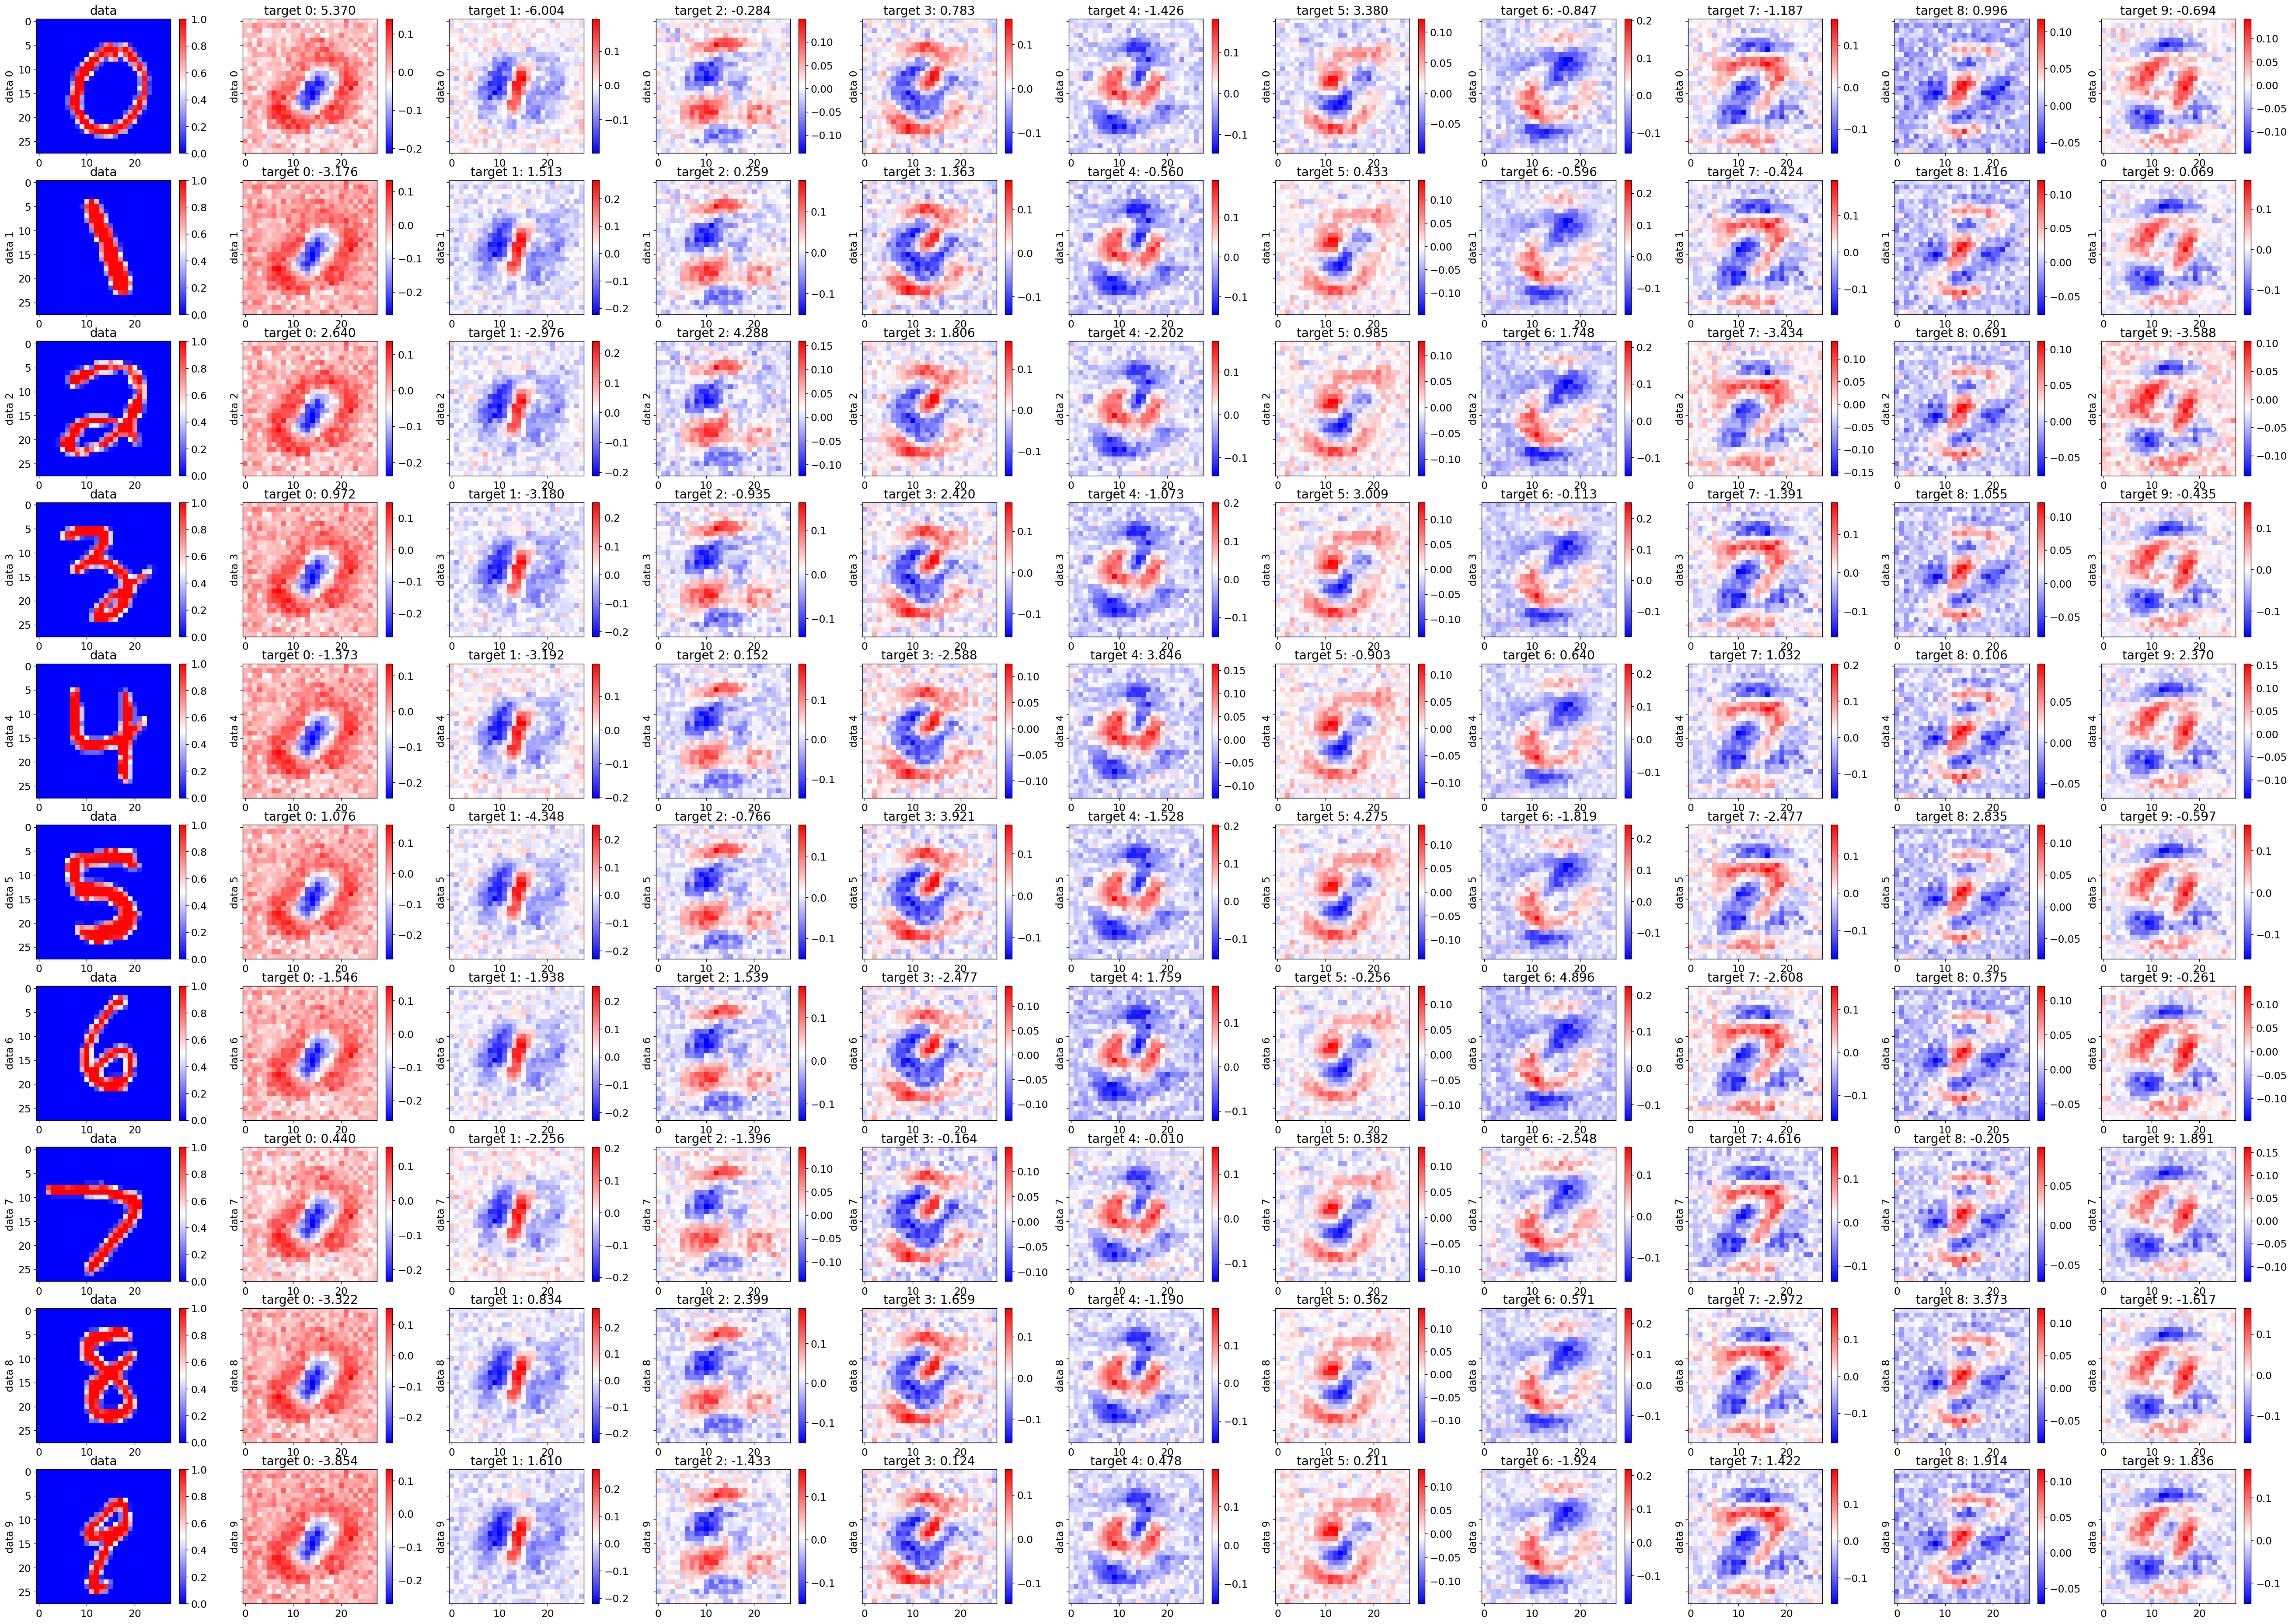

In [21]:
idx = 8

nrows, ncols = len(LABELS), len(LABELS)+1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=True, 
    dpi=120
)

for idx_label, label in enumerate(LABELS):
    ax = axs[idx_label][0]
    im = ax.imshow(X_s[idx_label][idx].squeeze().cpu(), cmap='bwr')
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_title(f"data")
    ax.set_ylabel(f"data {label}")

    pred = model(X_s[idx_label][idx]).cpu()[0]

    for idx_target, target_label in enumerate(LABELS):
        ax = axs[idx_label][idx_target+1]
        im = ax.imshow(attribs[idx_label][idx_target][idx].squeeze().cpu(), cmap='bwr')
        cbar = ax.figure.colorbar(im, ax=ax)
        ax.set_title(f"target {target_label}: {pred[idx_target]:.3f}")
        ax.set_ylabel(f"data {label}")

#### average of all attributions 

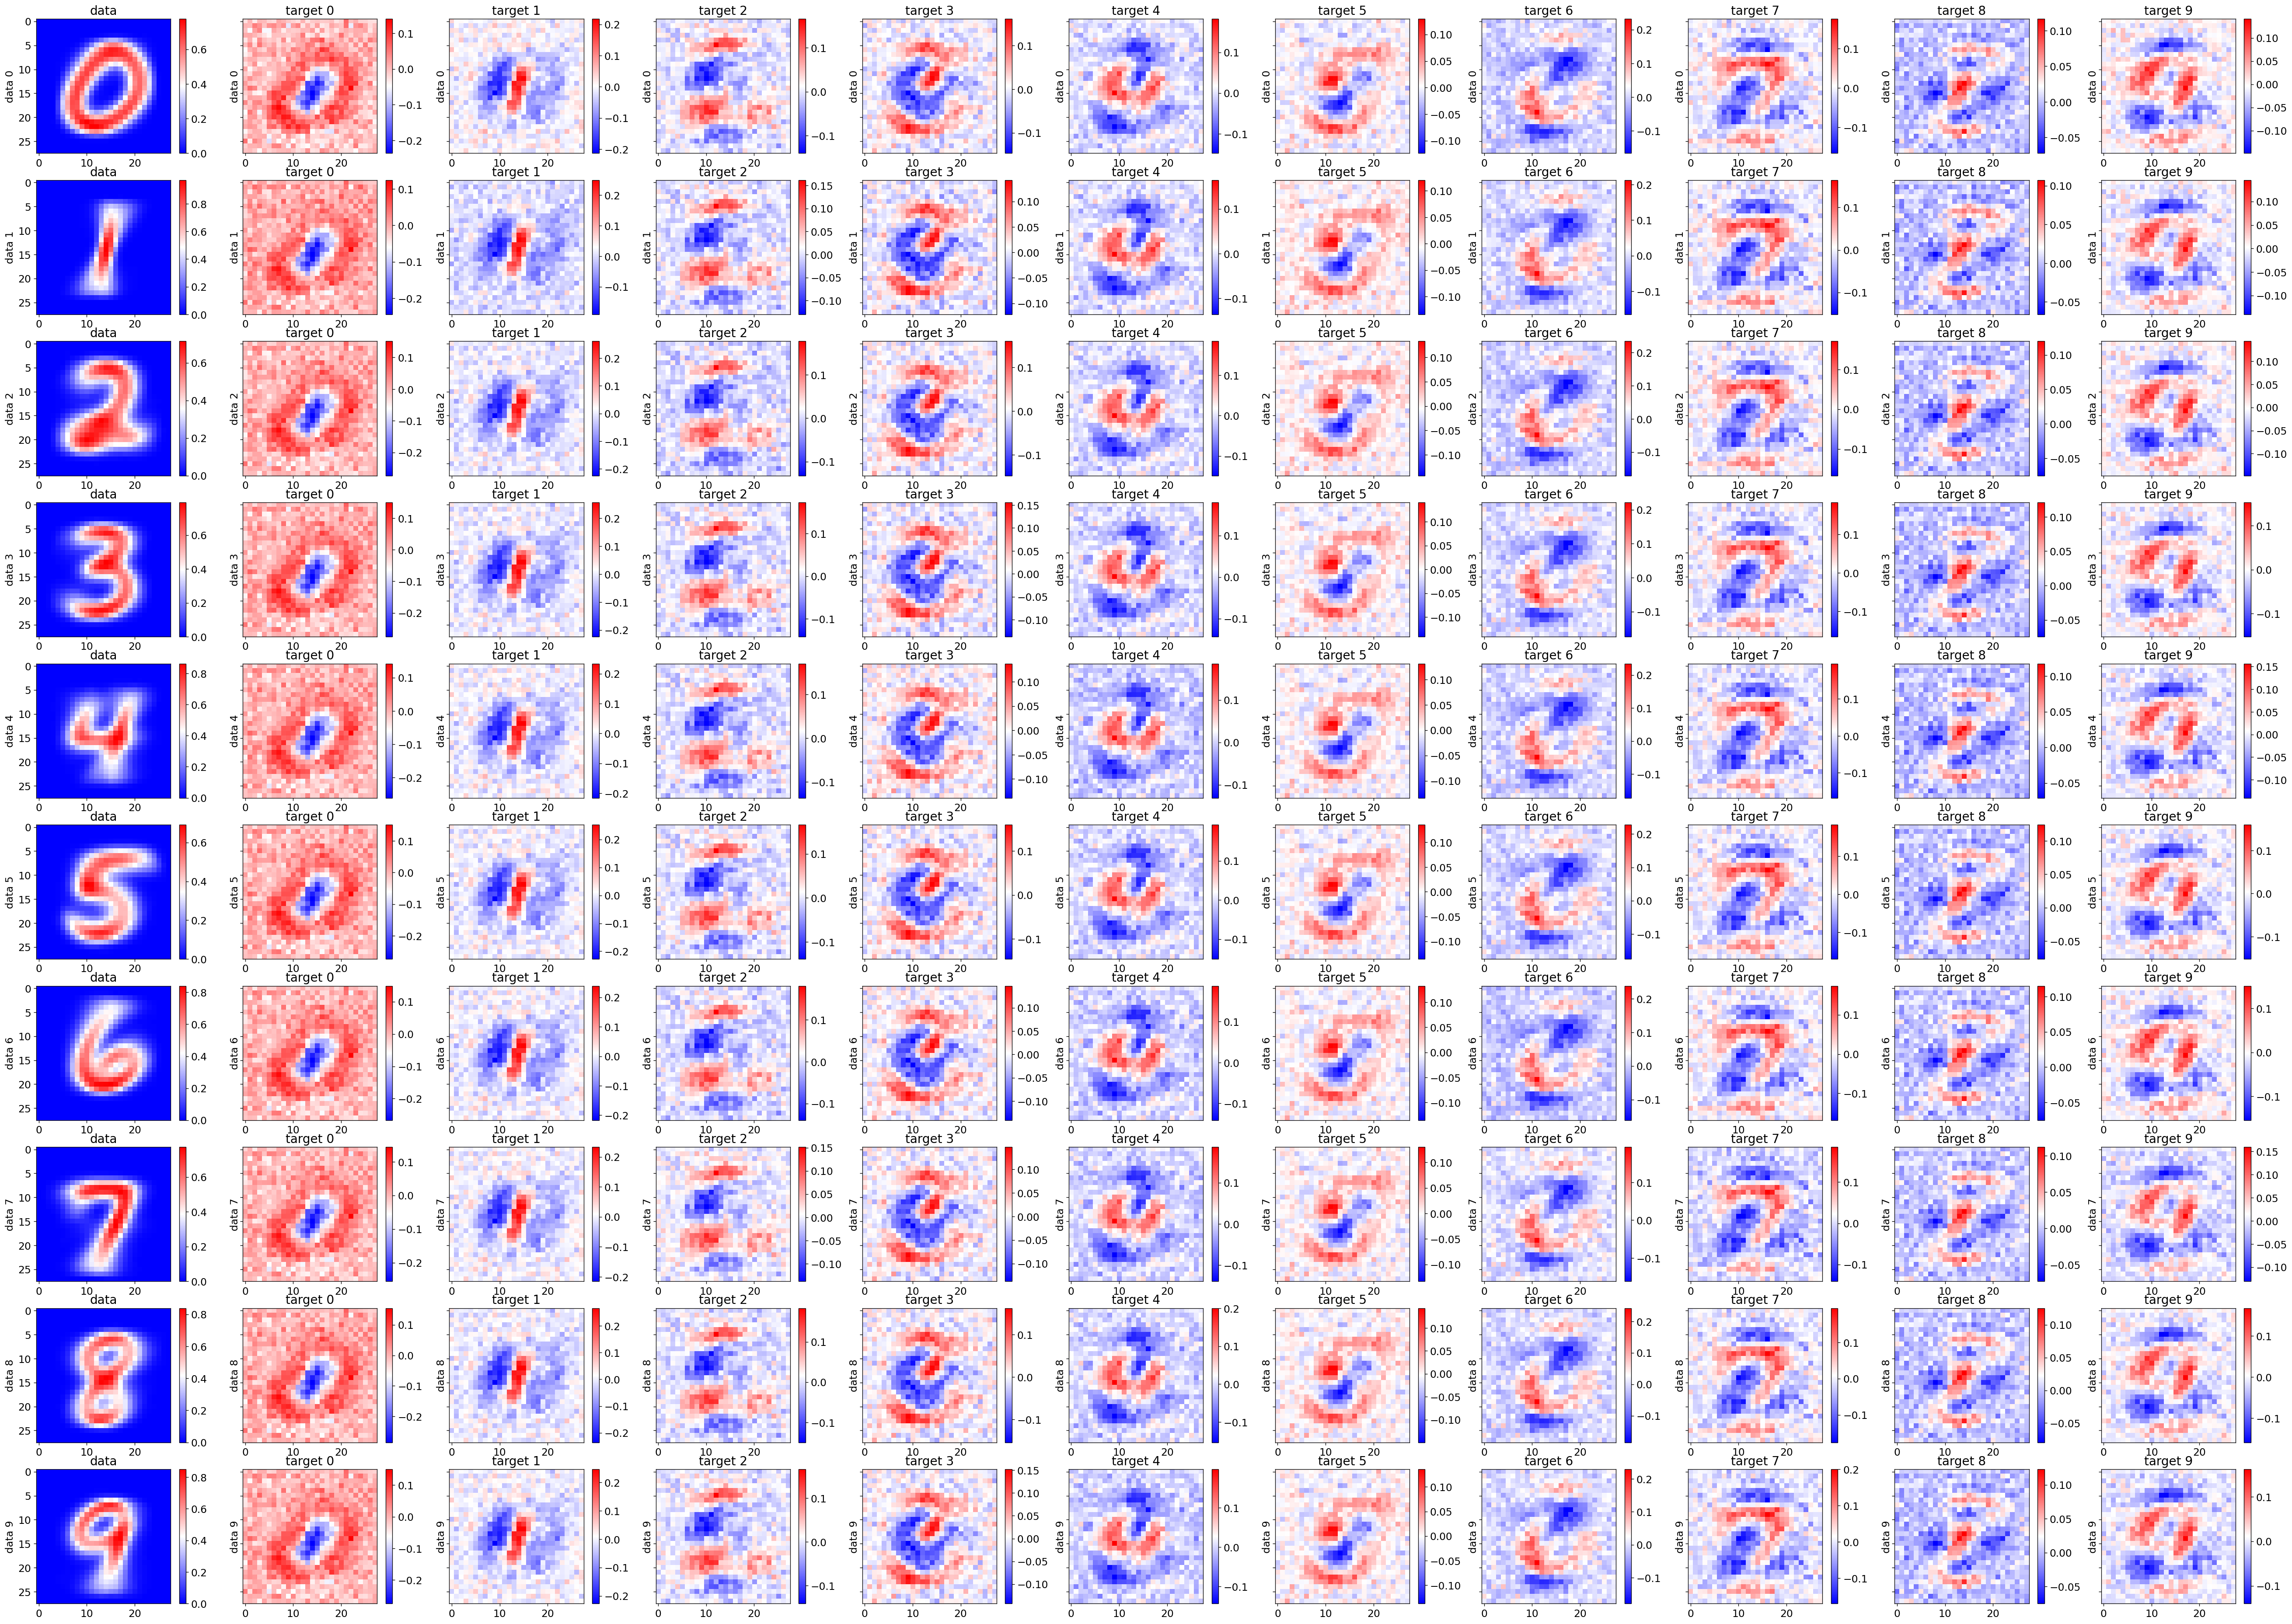

In [22]:
nrows, ncols = len(LABELS), len(LABELS)+1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=True, 
    dpi=120
)

for idx_label, label in enumerate(LABELS):
    ax = axs[idx_label][0]
    im = ax.imshow(torch.mean(X_s[idx_label], dim=0).squeeze().cpu(), cmap='bwr')
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_title(f"data")
    ax.set_ylabel(f"data {label}")


    for idx_target, target_label in enumerate(LABELS):
        ax = axs[idx_label][idx_target+1]
        im = ax.imshow(torch.mean(attribs[idx_label][idx_target], dim=0).squeeze().cpu(), cmap='bwr')
        cbar = ax.figure.colorbar(im, ax=ax)
        ax.set_title(f"target {target_label}")
        ax.set_ylabel(f"data {label}")

#### attributions on the mean data sample

10it [00:00, 102.30it/s]


torch.Size([10, 1, 28, 28]) torch.cuda.DoubleTensor


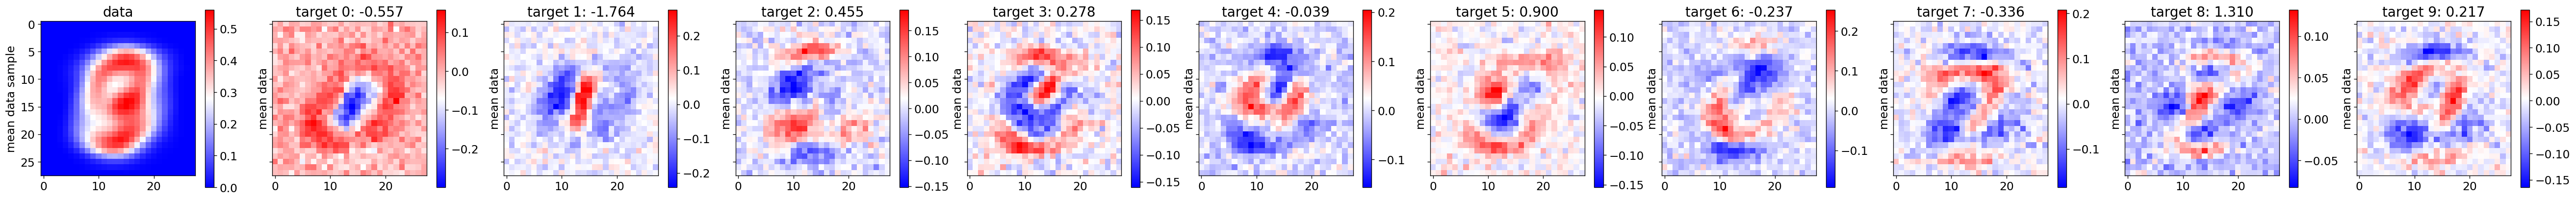

In [62]:
import numpy as np
from tqdm import tqdm
X_s = []
for idx in range(len(te_data)):
    X_s.append(te_data[idx][0])
X_s = torch.stack(X_s, dim=0).to(device)
X = torch.mean(X_s, dim=0)


attrs = []
for idx_target, _ in tqdm(enumerate(LABELS)):
    attr = saliency.attribute(X, target=idx_target)
    attrs.append(attr)
attrs = torch.stack(attrs, dim=0)
print(attrs.size(), attrs.type())

nrows, ncols = 1, len(LABELS)+1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=True, 
    dpi=120
)

ax = axs[0]
im = ax.imshow(X.squeeze().cpu(), cmap='bwr')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title(f"data")
ax.set_ylabel(f"mean data sample")


pred = model(X).cpu()[0]

for idx_target, target_label in enumerate(LABELS):
    ax = axs[idx_target+1]
    im = ax.imshow(attrs[idx_target].squeeze().cpu(), cmap='bwr')
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_title(f"target {target_label}: {pred[idx_target]:.3f}")
    ax.set_ylabel(f"mean data")

In [70]:
corrs = []
for idx, _ in enumerate(LABELS):
    corrs.append(np.corrcoef(
        X.squeeze().cpu().numpy().flatten(), 
        attrs[idx].squeeze().cpu().numpy().flatten()
    )[0, 1])
corrs

[-0.09144077653458957,
 -0.09936818719056029,
 -0.00864230131567566,
 -0.0007864563419384473,
 0.044090190510527254,
 0.08518662681255587,
 -0.03024457368399256,
 -0.004951587746597656,
 0.23684396182432887,
 0.0907422356902151]

#### attributions on a white noise data sample 

10it [00:00, 129.82it/s]


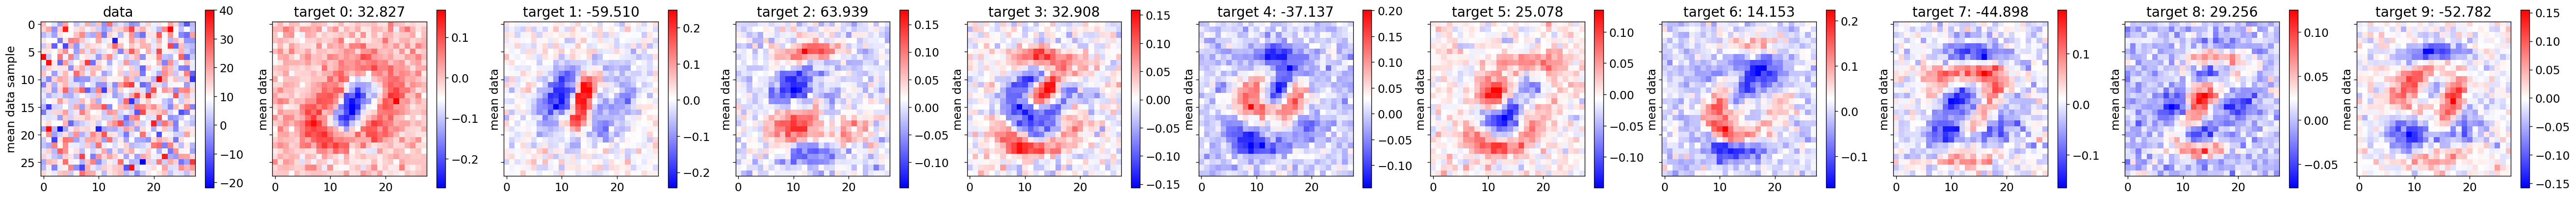

In [55]:
import numpy as np
from tqdm import tqdm
m, std = 10.0, 10.0 
X = torch.randn(X.size()) * std + m
X = X.to(device)

attrs = []
for idx_target, _ in tqdm(enumerate(LABELS)):
    attr = saliency.attribute(X, target=idx_target)
    attrs.append(attr)
attrs = torch.stack(attrs, dim=0)
attrs.size(), attrs.type()

nrows, ncols = 1, len(LABELS)+1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=True, 
    dpi=120
)

ax = axs[0]
im = ax.imshow(X.squeeze().cpu(), cmap='bwr')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title(f"data")
ax.set_ylabel(f"mean data sample")


pred = model(X).cpu()[0]

for idx_target, target_label in enumerate(LABELS):
    ax = axs[idx_target+1]
    im = ax.imshow(attrs[idx_target].squeeze().cpu(), cmap='bwr')
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_title(f"target {target_label}: {pred[idx_target]:.3f}")
    ax.set_ylabel(f"mean data")

#### white noise on mean data sample

10it [00:00, 117.91it/s]


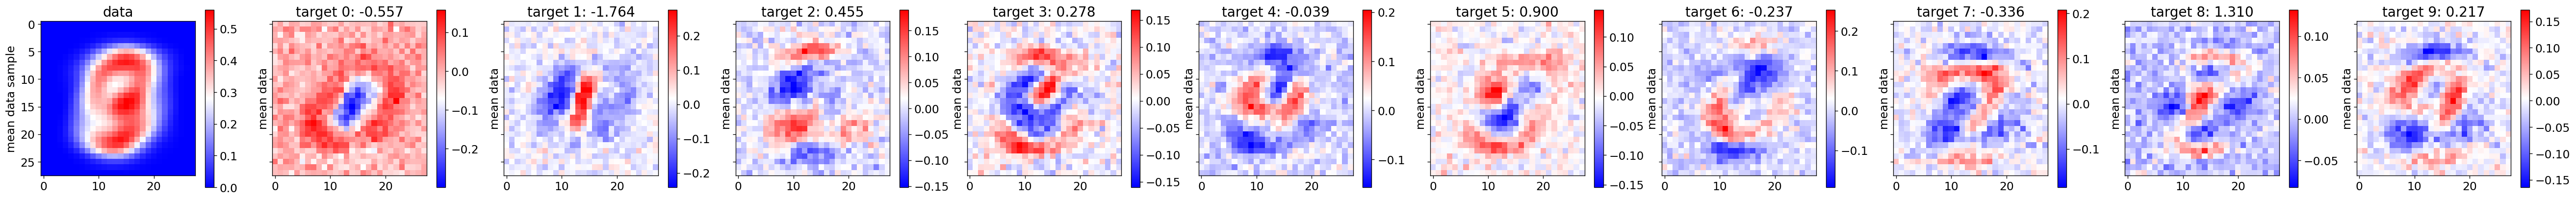

In [58]:
import numpy as np
from tqdm import tqdm
X_s = []
for idx in range(len(te_data)):
    X_s.append(te_data[idx][0])
X_s = torch.stack(X_s, dim=0).to(device)
X = torch.mean(X_s, dim=0)

m, std = 0.0, 0.0 
X += torch.randn(X.size()).to(device) * std + m

attrs = []
for idx_target, _ in tqdm(enumerate(LABELS)):
    attr = saliency.attribute(X, target=idx_target)
    attrs.append(attr)
attrs = torch.stack(attrs, dim=0)
attrs.size(), attrs.type()

nrows, ncols = 1, len(LABELS)+1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=True, 
    dpi=120
)

ax = axs[0]
im = ax.imshow(X.squeeze().cpu(), cmap='bwr')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title(f"data")
ax.set_ylabel(f"mean data sample")


pred = model(X).cpu()[0]

for idx_target, target_label in enumerate(LABELS):
    ax = axs[idx_target+1]
    im = ax.imshow(attrs[idx_target].squeeze().cpu(), cmap='bwr')
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_title(f"target {target_label}: {pred[idx_target]:.3f}")
    ax.set_ylabel(f"mean data")